# Data Analysis

In [2]:
! pip install azure-storage-blob azure-identity xgboost tensorflow pyspark windrose pywake

In [3]:
from azure.storage.blob import BlobServiceClient, BlobClient
import xgboost
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from dotenv import load_dotenv
import os
from tqdm import tqdm
import asyncio
from io import StringIO
from windrose import WindroseAxes

### Fetching azure blobs

Run download_files.py

### Make dataframes

In [4]:
data = {}
data_path = './data'
for csv_file in os.listdir(data_path):
    data[csv_file.replace('.csv', '')] = pd.read_csv(data_path+'/'+csv_file, low_memory=False)
    print("added: ", csv_file)

added:  activepower_DOW_2023_10min_avg.csv
added:  blade_angleA_DOW_2023_10min_avg.csv
added:  blade_angleB_DOW_2023_10min_avg.csv
added:  blade_angleC_DOW_2023_10min_avg.csv
added:  DOW_2023_Air_Pres_Hum.csv
added:  Dudgeon_coordinates.csv
added:  RAW_ActivePower_DOW_4_Nov_2023.csv
added:  RAW_Windspeed_DOW_4_Nov_2023.csv
added:  RPM_DOW_2023_10min_avg.csv
added:  windspeed_DOW_2023_10min_avg.csv
added:  wind_direction_DOW_2023_10min_avg.csv
added:  yaw_angle_DOW_2023_10min_avg.csv


In [5]:
ws_wd_yaw_10_min = pd.merge(data['windspeed_DOW_2023_10min_avg'], data['wind_direction_DOW_2023_10min_avg'], on='timestamp', how='outer')
ws_wd_yaw_10_min = pd.merge(ws_wd_yaw_10_min, data['yaw_angle_DOW_2023_10min_avg'],  on='timestamp', how='outer')

wd_ws_A01 = ws_wd_yaw_10_min[['timestamp', 'DOW-A01-WindSpeed', 'DOW-A01-WindDirection']].dropna()
wd_ws_F02 = ws_wd_yaw_10_min[['timestamp', 'DOW-F02-WindSpeed', 'DOW-F02-WindDirection']].dropna()
wd_ws_B01 = ws_wd_yaw_10_min[['timestamp', 'DOW-B01-WindSpeed', 'DOW-B01-WindDirection']].dropna()

### Wind direction

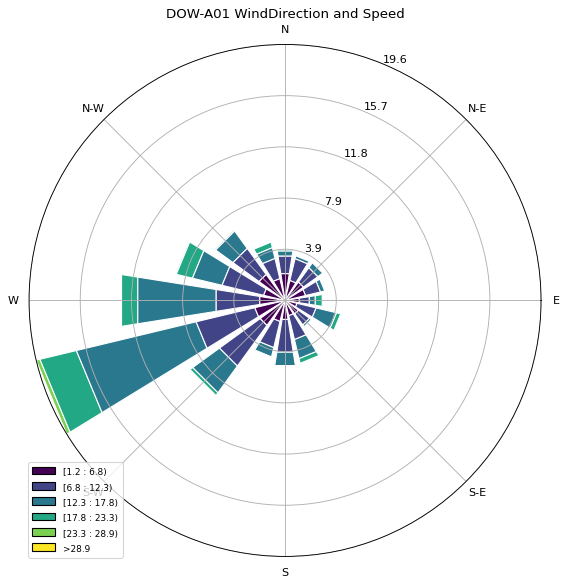

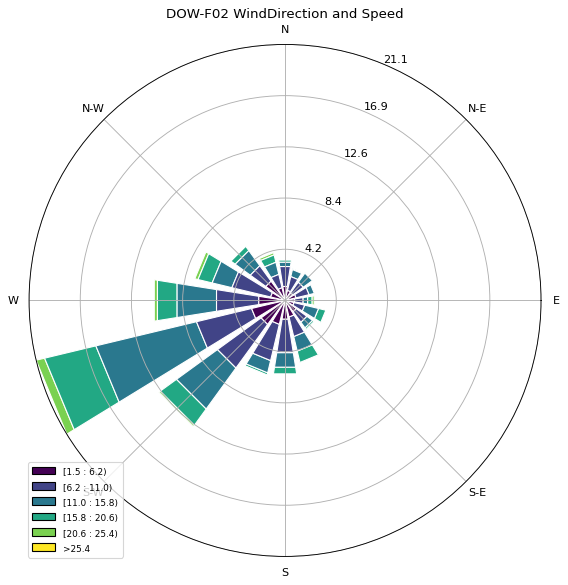

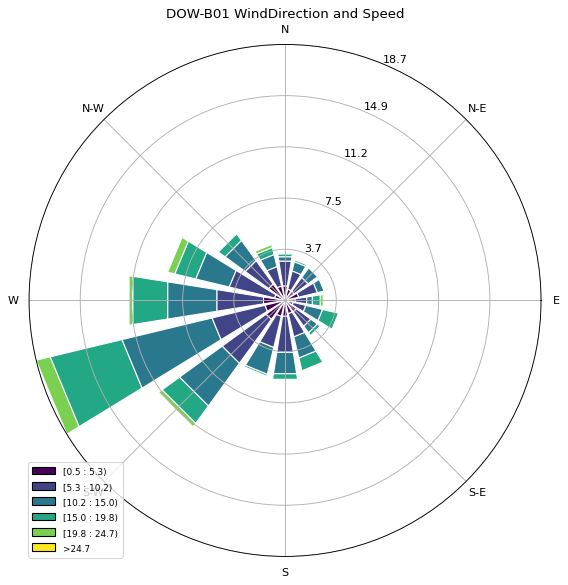

In [6]:

ax1 = WindroseAxes.from_ax()
ax1.bar(wd_ws_A01['DOW-A01-WindDirection'], wd_ws_A01['DOW-A01-WindSpeed'], normed=True, opening=0.8, edgecolor='white')
ax1.set_legend()

ax1.set_title("DOW-A01 WindDirection and Speed")


ax2 = WindroseAxes.from_ax()
ax2.bar(wd_ws_F02['DOW-F02-WindDirection'], wd_ws_F02['DOW-F02-WindSpeed'], normed=True, opening=0.8, edgecolor='white')
ax2.set_legend()

ax2.set_title("DOW-F02 WindDirection and Speed")


ax3 = WindroseAxes.from_ax()
ax3.bar(wd_ws_B01['DOW-B01-WindDirection'], wd_ws_B01['DOW-B01-WindSpeed'], normed=True, opening=0.8, edgecolor='white')
ax3.set_legend()

ax3.set_title("DOW-B01 WindDirection and Speed")



plt.show()

### Yaw offset

# massive problem

       DOW-A01-WindDirection  DOW-A01-NacelleDirection  DOW-A01-YawOffset
12060             281.023494                281.555631          -0.532137
12106             273.519648                274.056110          -0.536463
12121             268.420345                267.670896           0.749450
12133             267.195977                266.262083           0.933893
12157             271.505079                270.571289           0.933790

       DOW-A01-WindDirection  DOW-A01-NacelleDirection  DOW-A01-YawOffset
12400             273.972922                272.419842           1.553081
12425             266.136977                264.786710           1.350267
12352             283.815786                282.585359           1.230427
12505             270.144382                268.965236           1.179146
12488             266.365502                265.233276           1.132226
12388             262.914886                261.845767           1.069119
12133             267.195977         

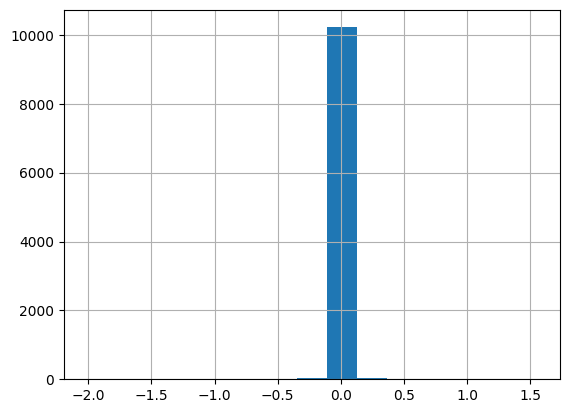

In [7]:
yaw_offset_A01 = ws_wd_yaw_10_min[['DOW-A01-WindDirection', 'DOW-A01-NacelleDirection']].dropna()

yaw_offset_A01['DOW-A01-YawOffset'] = yaw_offset_A01['DOW-A01-WindDirection'] - yaw_offset_A01['DOW-A01-NacelleDirection']


yaw_offset_A01['DOW-A01-YawOffset'].hist(bins=15)
print(yaw_offset_A01[yaw_offset_A01['DOW-A01-YawOffset'].round() != 0].head())
print()
print(yaw_offset_A01.nlargest(n=10, columns=['DOW-A01-YawOffset']))

### Turbulence correlation

In [8]:
import math
from datetime import datetime, timedelta
pd.options.mode.copy_on_write = True

def calculate_TI(ws_df, interval = 5):
    bin_delta = timedelta(minutes=interval)
    is_series = False
    try:
        ws_column = [s for s in ws_df.columns if 'WindSpeed' in s][0]
    except:
        if 'WindSpeed' in ws_df.name:
            ws_column = ws_df.name
            is_series = True
        else:
            raise KeyError('No windspeed column found')
        
    TI_label = ws_column.replace('WindSpeed', 'TI')

    print('Using column: ', ws_column)
    print('Resuts into column: ', TI_label)
    print('Input is series: ', is_series)

    def calculate_rolling_TI_std():
        if is_series:
            mean = ws_df.rolling(window = bin_delta, min_periods = 20).mean()
            std = ws_df.rolling(window = bin_delta, min_periods = 20).std()
            ti = std/mean
            ti = ti.rename(TI_label)

        else:
            mean = ws_df[ws_column].rolling(window = bin_delta, min_periods = 20).mean()
            std = ws_df[ws_column].rolling(window = bin_delta, min_periods = 20).std()
            ti = std/mean
            ti = ti.rename(columns = {ws_column: TI_label})
        return ti
    
    ti = calculate_rolling_TI_std()
    return ti


def timestamp_to_datetime_index(df):
    if 'timestamp' not in df.columns:
        raise KeyError('timestamp not in dataframe')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    return df


### Fetching D05 and D06 data, for analysis.

In [25]:

pivot_df = data['RAW_Windspeed_DOW_4_Nov_2023'].pivot(index='source_timestamp', columns='tag', values='double_value')
pivot_df = pivot_df.reset_index()
pivot_df = pivot_df.rename(columns = {'source_timestamp': 'timestamp'})
pivot_df = timestamp_to_datetime_index(pivot_df)


J04_raw_ws = pivot_df['DOW-J04-WindSpeed'].dropna()
T05_raw_ws = pivot_df['DOW-T05-WindSpeed'].dropna()

pivot_df = data['RAW_ActivePower_DOW_4_Nov_2023'].pivot(index='source_timestamp', columns='tag', values='double_value')
pivot_df = pivot_df.reset_index()
pivot_df = pivot_df.rename(columns = {'source_timestamp': 'timestamp'})
pivot_df = timestamp_to_datetime_index(pivot_df)

J04_raw_ap = pivot_df['DOW-J04-ActivePower'].dropna()
T05_raw_ap = pivot_df['DOW-T05-ActivePower'].dropna()

T05_wd = data['wind_direction_DOW_2023_10min_avg'][['timestamp', 'DOW-T05-WindDirection']]
J04_wd = data['wind_direction_DOW_2023_10min_avg'][['timestamp', 'DOW-J04-WindDirection']]


### Highlighting targeted turbines 

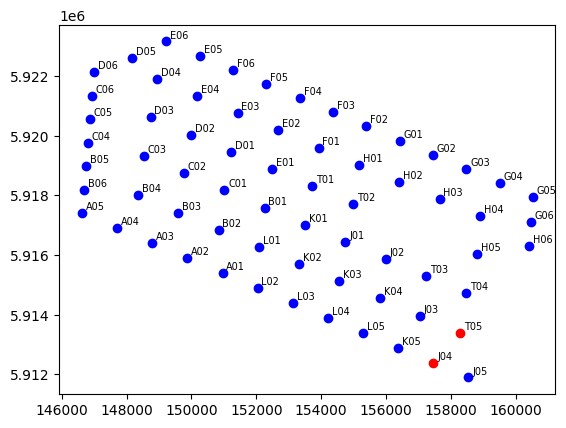

In [24]:
from demo import plot_DOW_layout

plot_DOW_layout(highlight=['J04', 'T05'])

### Calculating TI

In [26]:

T05_TI = calculate_TI(ws_df=T05_raw_ws)
J04_TI = calculate_TI(ws_df=J04_raw_ws)

Using column:  DOW-T05-WindSpeed
Resuts into column:  DOW-T05-TI
Input is series:  True
Using column:  DOW-J04-WindSpeed
Resuts into column:  DOW-J04-TI
Input is series:  True


In [34]:
merge_test = pd.DataFrame({J04_TI.name: J04_TI.dropna(), T05_TI.name:T05_TI.dropna()})
print(J04_raw_ws.dropna().head(20))

timestamp
2023-11-04 04:15:28.525000+00:00    7.17
2023-11-04 04:15:29.522000+00:00    7.89
2023-11-04 04:15:30.524000+00:00    7.44
2023-11-04 04:15:32.522000+00:00    7.82
2023-11-04 04:15:33.524000+00:00    8.88
2023-11-04 04:15:34.590000+00:00    8.10
2023-11-04 04:15:36.524000+00:00    7.53
2023-11-04 04:15:37.525000+00:00    7.31
2023-11-04 04:15:39.624000+00:00    6.62
2023-11-04 04:15:40.572000+00:00    7.42
2023-11-04 04:15:42.571000+00:00    6.78
2023-11-04 04:15:43.523000+00:00    6.03
2023-11-04 04:15:44.524000+00:00    5.77
2023-11-04 04:15:46.571000+00:00    5.60
2023-11-04 04:25:00.660000+00:00    8.26
2023-11-04 04:25:03.509000+00:00    8.09
2023-11-04 04:25:04.518000+00:00    8.33
2023-11-04 04:25:05.512000+00:00    8.82
2023-11-04 04:25:06.512000+00:00    8.70
2023-11-04 04:25:15.511000+00:00    8.09
Name: DOW-J04-WindSpeed, dtype: float64


### Wind Direction this day

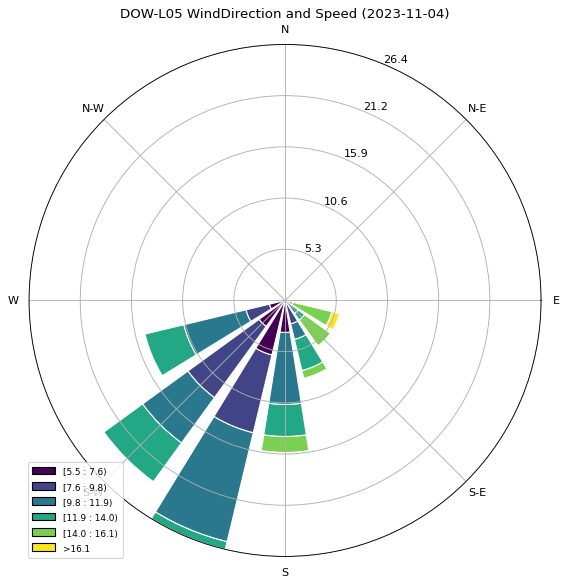

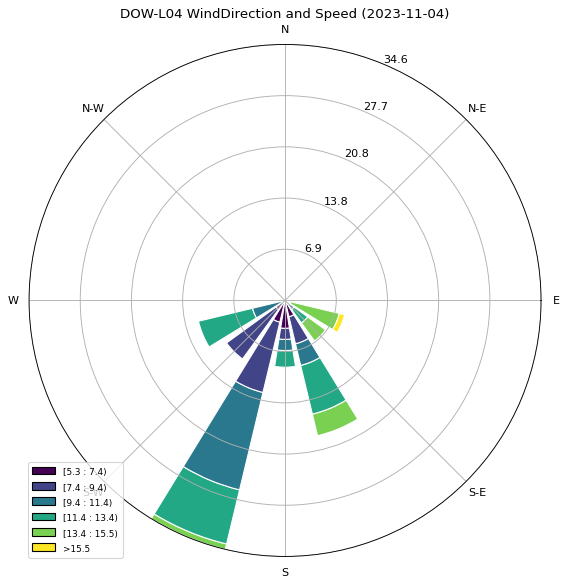

In [23]:
wd_ws_J04 = ws_wd_yaw_10_min[['timestamp', 'DOW-J04-WindSpeed', 'DOW-J04-WindDirection']].dropna()
wd_ws_T05 = ws_wd_yaw_10_min[['timestamp', 'DOW-T05-WindSpeed', 'DOW-T05-WindDirection']].dropna()

wd_ws_J04 = timestamp_to_datetime_index(wd_ws_J04)
wd_ws_T05 = timestamp_to_datetime_index(wd_ws_T05)

wd_ws_J04_raw_day = wd_ws_J04.loc['2023-11-04']
wd_ws_T05_raw_day = wd_ws_T05.loc['2023-11-04']




ax6 = WindroseAxes.from_ax()
ax6.bar(wd_ws_T05_raw_day['DOW-L05-WindDirection'], wd_ws_T05_raw_day['DOW-L05-WindSpeed'], normed=True, opening=0.8, edgecolor='white')
ax6.set_legend()
ax6.set_title("DOW-T05 WindDirection and Speed (2023-11-04)")

ax5 = WindroseAxes.from_ax()
ax5.bar(wd_ws_J04_raw_day['DOW-J04-WindDirection'], wd_ws_J04_raw_day['DOW-J04-WindSpeed'], normed=True, opening=0.8, edgecolor='white')
ax5.set_legend()
ax5.set_title("DOW-J04 WindDirection and Speed (2023-11-04)")

plt.show()
